#  Spam/Ham Classification

# I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

class bcolor:
   BLACK = '\033[40m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

def print_passed(str_in):
  print(bcolor.BLACK + bcolor.YELLOW + bcolor.BOLD + str_in + bcolor.END)

### Loading in the Data

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

The `train` DataFrame contains labeled data that we will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. We will predict labels for these emails.

In [3]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if our data contains any missing values. 

In [4]:
print('Before imputation:') 
print(original_training_data.isnull().sum()) 
original_training_data = original_training_data.fillna('') 
print('------------')
print('After imputation:') 
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


Print the text of the first ham (i.e. 1st row) and the first spam email in the original training set.

In [5]:
first_ham = original_training_data[original_training_data['spam'] == 0]['email'].iloc[0]
first_spam = original_training_data[original_training_data['spam'] == 1]['email'].iloc[0 ]

print('The text of the first Ham:')
print('------------')
print(first_ham)

print('The text of the first Spam:')
print('------------')
print(first_spam)

The text of the first Ham:
------------
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

The text of the first Spam:
------------
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



Different between the two emails that might relate to the identification of spam are:
- The spam email seems to be written in html.
- The ham email is not be written in html and seems to be just a normal string.

## Training Validation Split

In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(
    original_training_data, test_size=0.1, random_state=42)

In [8]:
print(train.shape, val.shape)   # 더해서 8342 맞음

(7513, 4) (835, 4)


# Basic Feature Engineering

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for i in texts:
        row_array = []
        for j in words:
            if j in i:
                row_array.append(1)
            else:
                row_array.append(0)
        indicator_array.append(row_array)

    return indicator_array

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. 

If the feature is itself a binary indicator (such as whether a certain word occurs in the text), this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

In [11]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


We can create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure that we only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

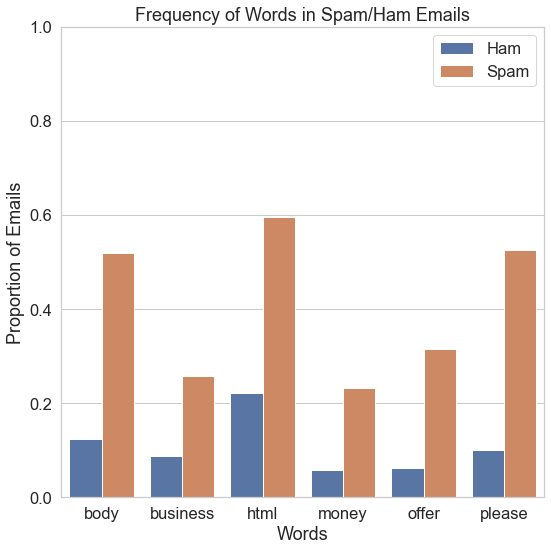

In [12]:
# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train=train.reset_index(drop=True) 

some_words = ['body', 'html', 'please', 'money', 'business', 'offer']
Phi_train = words_in_texts(some_words, train['email'])

df = pd.DataFrame(data = Phi_train, columns = some_words)
df['label'] = train['spam']

plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.title("Frequency of Words in Spam/Ham Emails")
plt.tight_layout()
plt.show()

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

/Users/qtle/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/qtle/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


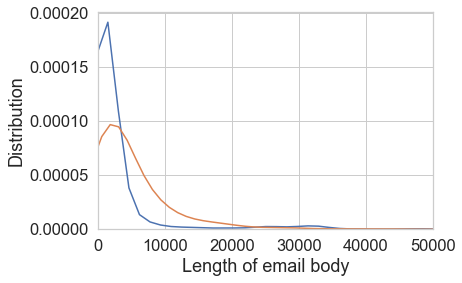

In [13]:
ham_lens = train[train['spam'] == 0]['email'].agg(len) 
spam_lens = train[train['spam'] == 1]['email'].agg(len)

sns.distplot(ham_lens, label='Ham', hist=False) 
sns.distplot(spam_lens, label='Spam', hist=False) 
plt.xlim(0, 50000)
plt.xlabel("Length of email body") 
plt.ylabel("Distribution")
plt.show()

## Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

We will use 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

- `X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

- `Y_train` should be a vector of the correct labels for each email in the training set.

In [14]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = np.array(words_in_texts(some_words, train['email']))
Y_train = train['spam'].values

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

Now we have matrices we can give to scikit-learn! 

- Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`.

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
Y_predict = model.predict(X_train) 
training_accuracy = model.score(X_train, Y_train)

print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`?

In [16]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train == 1)

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set?

In [18]:
zero_predictor_acc = np.mean(Y_train == 0)
zero_predictor_recall = 0 / (0 + zero_predictor_fn)

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained above

In [20]:
TP = sum((Y_train == 1) & (Y_predict == 1)) 
TN = sum((Y_train == 0) & (Y_predict == 0)) 
FP = sum((Y_train == 0) & (Y_predict == 1)) 
FN = sum((Y_train == 1) & (Y_predict == 0)) 
logistic_predictor_precision = TP / (TP + FP) 
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_far = FP / (FP + TN)

- Our logistic regression classifier is slightly better than guessing ham for every email(75.6% > 74.5%).
- The encoded features in X_train mostly contains 0's more than 1's. Which means the words we've chosen as
our features aren't actually present in many of the emails, so the classifier can't use them to distinguish
between ham and spam emails.
- The false-alarm rate for logistic regression is too high(~2.2%). So I would prefer zero predictor classifier.
Because with it, at least I wouldn't be discarding any important emails.

# Part II - Optimization

Improving the model to get better accuracy

I will count the most commonly appeared words in ham and spam emails, then find out the most different words in spam and ham emails. We can use these words to distinguish between ham and spam emails.

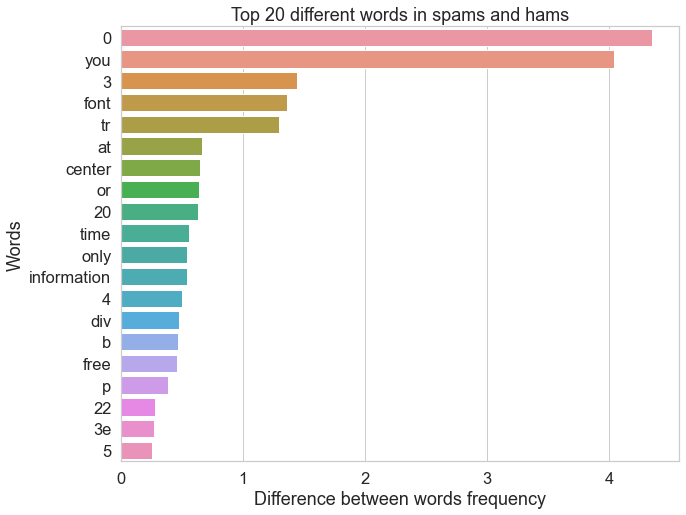

In [23]:
import re

#words counter
def words_count(df): 
    words = {}
    for i in df['email']:
        w = re.findall('\w+', i) 
        for j in w:
            if j in words:
                words[j] = words[j] + 1
        else:
            words[j] = 1
    return words

#different words frequency counter
def word_diff_count(df1, df2): 
    words = {}
    words1 = words_count(df1) 
    words2 = words_count(df2) 
    for i in words1:
        if i in words2:
    #average appeared frequency of each word in a spams - average appeared frequency of each word in a hams
            words[i] = abs((words1[i]/len(df1)) - (words2[i]/len(df2)))
        else:
            words[i] = words1[i]/len(df1)
    return words

hams = train[train['spam'] == 0]
spams = train[train['spam'] == 1]
diff_words = pd.Series(word_diff_count(spams, hams)).sort_values(ascending = False)


plt.figure(figsize= (10,8))
sns.barplot(x = diff_words.head(20).values, y = diff_words.head(20).keys()) 
plt.title('Top 20 different words in spams and hams')
plt.ylabel('Words')
plt.xlabel('Difference between words frequency')
plt.show()

### Precision-Recall Curve

accuracy:  0.914548116597897
accuracy(on validation set):  0.9053892215568863


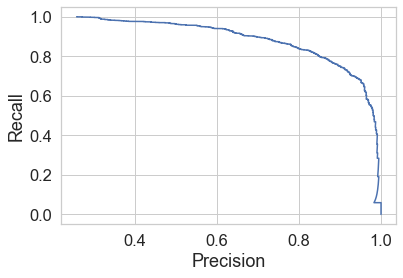

In [25]:
from sklearn.metrics import precision_recall_curve

#New model:
training_words = np.array(diff_words.iloc[0:100].index.tolist())

new_X_train = np.array(words_in_texts(training_words, train['email'])) 
new_Y_train = train['spam'].values
new_model = LogisticRegression(max_iter = 300) 
new_model.fit(new_X_train, new_Y_train)

print("accuracy: ", new_model.score(new_X_train, new_Y_train))

#Test on validation set
new_X_train2 = np.array(words_in_texts(training_words, val['email']))
new_Y_train2 = val['spam'].values
print("accuracy(on validation set): ", new_model.score(new_X_train2, new_Y_train2))

#Precision-Recall Curve:
new_Y_predict = new_model.predict_proba(new_X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(new_Y_train, new_Y_predict) 
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()